# Experiment 2

Preprocessing Techniques -> Grayscale + Gaussian Blur + Canny Edge Detection

## Data Preprocessing

In [1]:
from helpers import edge_preprocess_and_save_dataset
from tensorflow.keras.utils import image_dataset_from_directory

2025-05-08 23:18:21.496190: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-08 23:18:21.676400: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746742701.763696  178210 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746742701.780171  178210 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746742701.891901  178210 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# We would perform edge preprocessing on the original dataset and save a new
# dataset of preprocessed images

# Directory for the original dataset
original_dataset_dir = "./dataset"
# Directory for the preprocessed dataset
preprocessed_dataset_dir = "./edge_preprocessed_dataset"

# Use the helper function to preprocess the dataset and save it
edge_preprocess_and_save_dataset(
    input_dir=original_dataset_dir,
    output_dir=preprocessed_dataset_dir,
)

In [3]:
# Loading the preprocessed dataset
image_size = (256, 256)
train_dataset = image_dataset_from_directory(
    "edge_preprocessed_dataset/train",
    label_mode="categorical",
    image_size=image_size,
    batch_size=32,
    shuffle=True,
    seed=123,
)

test_dataset = image_dataset_from_directory(
    "edge_preprocessed_dataset/test",
    label_mode="categorical",
    image_size=image_size,
    batch_size=32,
    shuffle=False,
    seed=123,
)

val_dataset = image_dataset_from_directory(
    "edge_preprocessed_dataset/val",
    label_mode="categorical",
    image_size=image_size,
    batch_size=32,
    shuffle=False,
    seed=123,
)


Found 1336 files belonging to 2 classes.


I0000 00:00:1746742726.159412  178210 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4396 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 238 files belonging to 2 classes.
Found 234 files belonging to 2 classes.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from helpers import get_sample_images, plot_sample_images

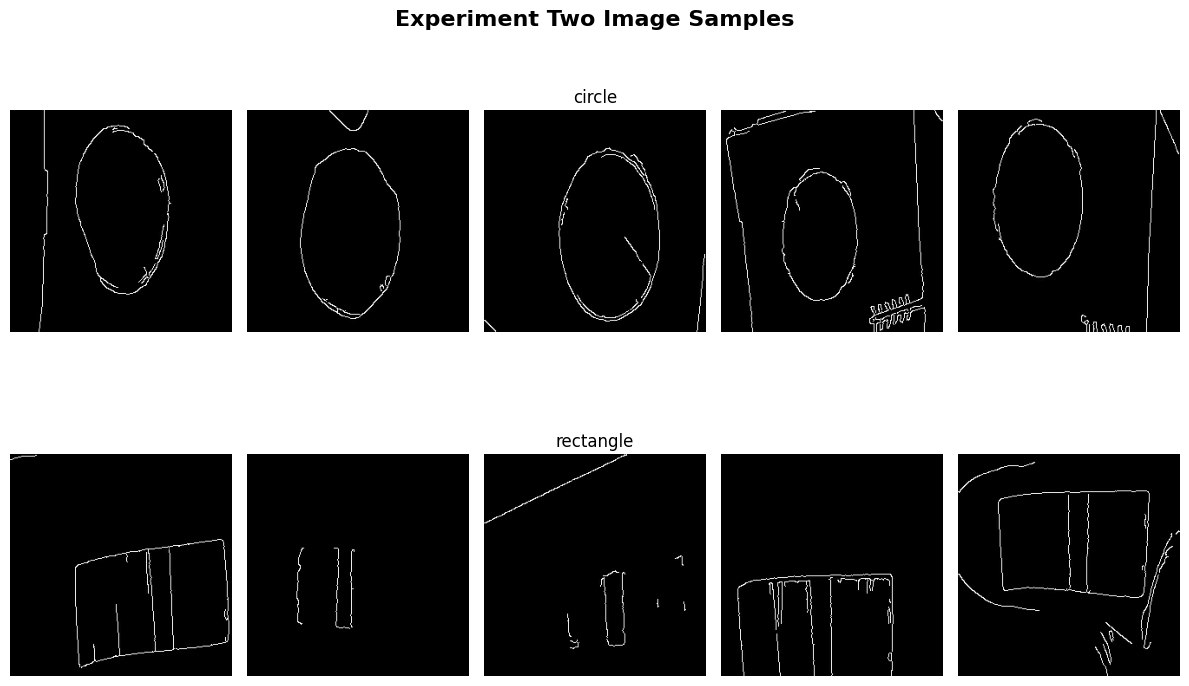

In [5]:
# Visualizing samples from the preprocessed dataset
class_names = train_dataset.class_names
sample_images = get_sample_images(train_dataset, class_names)
plot_sample_images(
    class_names,
    sample_images,
    filename="experiment_two_sample_images",
    title="Experiment Two Image Samples"
)

## Model Creation and Training

In [6]:
import tensorflow as tf
from tensorflow.keras.models import load_model

In [7]:
# For this experiment, we would perform transfer learning with the same
# model architecture as experiment 1
# ----- Function to create resnet50 model ----- #
def create_resnet50(input_shape):
    # ----- Input layer ----- #
    input_layer = tf.keras.Input(shape=input_shape)

    # ----- Load ResNet50 model without the top classification layer ----- #
    resnet50_model = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape)
    resnet50_model.trainable = False  # Freeze the ResNet50 layers

    # ----- Preprocess the input data ----- #
    x = tf.keras.applications.resnet50.preprocess_input(input_layer)

    # ----- Feature extraction ----- #
    features = resnet50_model(x)

    # Custom classification head
    # ----- Global Average Pooling Layer ----- #
    flat = tf.keras.layers.GlobalAveragePooling2D()(features)

    # ----- Dense layers ----- #
    dense1 = tf.keras.layers.Dense(units=32, kernel_regularizer="l2", activation="relu")(flat)
    dense1 = tf.keras.layers.Dropout(0.3)(dense1)

    # Output layer
    outputs = tf.keras.layers.Dense(2, activation="softmax")(dense1)

    # ----- Construct the final model with the input and output layers ----- #
    model = tf.keras.Model(input_layer, outputs)
    return model


In [8]:
resnet50 = create_resnet50(
    input_shape=(256, 256, 3),
)
resnet50.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 256, 256)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 256, 256)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 256, 256)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 256, 256,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 8, 8,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │     65,568 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │         66 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,653,346 (90.23 MB)

 Trainable params: 65,634 (256.38 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
resnet50.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
    tf.keras.callbacks.ModelCheckpoint(
        "./models/experiment_two_resnet50.keras",
        monitor="val_accuracy",
        save_best_only=True
    )
]


In [10]:
# ----- Initiating training ------ #
resnet50_history = resnet50.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=callbacks,
)

Epoch 1/10


I0000 00:00:1746742732.747064  178539 service.cc:152] XLA service 0x7f094c013010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746742732.748052  178539 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-05-08 23:18:52.921993: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746742733.993653  178539 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-05-08 23:18:55.105096: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3985', 468 bytes spill stores, 468 bytes spill loads

2025-05-08 23:18:55.228456: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fus

 1/42 ━━━━━━━━━━━━━━━━━━━━ 6:49 10s/step - accuracy: 0.5938 - loss: 1.5702

I0000 00:00:1746742739.693761  178539 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8748 - loss: 0.8210

2025-05-08 23:19:05.607886: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3985', 476 bytes spill stores, 476 bytes spill loads

2025-05-08 23:19:05.684849: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3985', 588 bytes spill stores, 588 bytes spill loads

2025-05-08 23:19:05.732964: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3985', 716 bytes spill stores, 716 bytes spill loads



42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8766 - loss: 0.8151

2025-05-08 23:19:13.837956: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1757', 52 bytes spill stores, 52 bytes spill loads

2025-05-08 23:19:14.261948: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1757', 4708 bytes spill stores, 6664 bytes spill loads



42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 419ms/step - accuracy: 0.8783 - loss: 0.8093 - val_accuracy: 1.0000 - val_loss: 0.3092
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9964 - loss: 0.2805 - val_accuracy: 1.0000 - val_loss: 0.1881
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9952 - loss: 0.1817 - val_accuracy: 1.0000 - val_loss: 0.1312
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9985 - loss: 0.1279 - val_accuracy: 1.0000 - val_loss: 0.0979
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9985 - loss: 0.0992 - val_accuracy: 1.0000 - val_loss: 0.0756
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9995 - loss: 0.0779 - val_accuracy: 1.0000 - val_loss: 0.0602
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9997 - loss: 0.0615 - val_accuracy: 1.0000 - val_loss: 0.0504
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 1.0000 - loss: 0.0524 - val_accuracy: 1.0000 - val_loss: 

## Model Evaluation

In [11]:
from helpers import plot_training_curves, show_evaluation_report

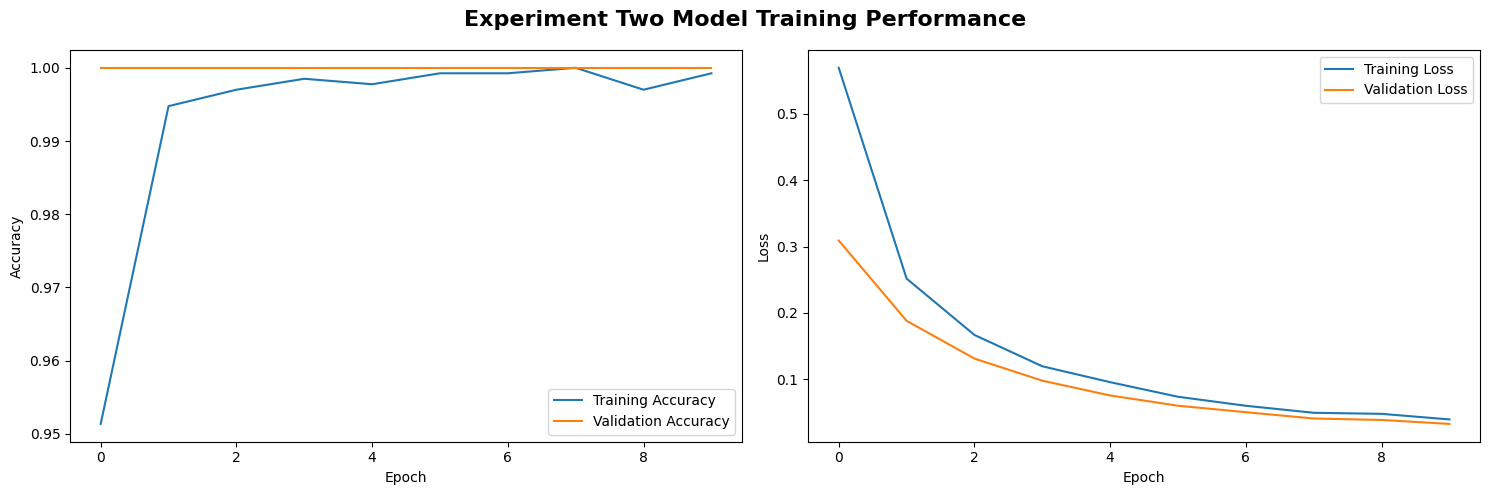

In [12]:
plot_training_curves(
    resnet50_history.history,
    filename="experiment_two_training_curves.png",
    title="Experiment Two Model Training Performance"
)

In [13]:
# Load the best model
best_model = tf.keras.models.load_model("./models/experiment_two_resnet50.keras")

2025-05-08 23:19:54.607008: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step

2025-05-08 23:19:59.307814: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1704', 52 bytes spill stores, 52 bytes spill loads

2025-05-08 23:19:59.484045: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1704', 560 bytes spill stores, 560 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 697ms/step


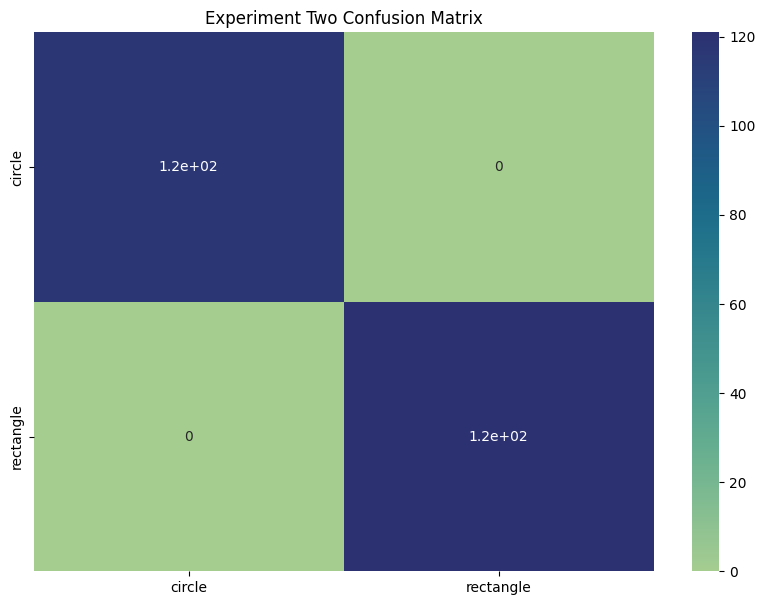



Classification Report:

              precision    recall  f1-score   support

      circle       1.00      1.00      1.00       117
   rectangle       1.00      1.00      1.00       121

    accuracy                           1.00       238
   macro avg       1.00      1.00      1.00       238
weighted avg       1.00      1.00      1.00       238



Model Accuracy: 1.00


In [14]:
# ----- Evaluating the model ------ #
show_evaluation_report(
    best_model,
    [test_dataset],
    filename="experiment_two_confusion_matrix.png",
    matrix_title="Experiment Two Confusion Matrix"
)